In [1]:
import os 

#sys.path.insert(0,"/homes/o23gauvr/Documents/thèse/code/FASCINATION/")
running_path = "/Odyssey/private/o23gauvr/code/FASCINATION/"
os.chdir(running_path)

In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
import pickle
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import math
from scipy.signal import butter, filtfilt
from scipy.ndimage import convolve

#import cartopy.crs as ccrs
from IPython.display import display, HTML


import src.differentiable_fonc as DF

from src.utils import *


In [3]:
plt.style.use('ggplot')

In [4]:
cmap = plt.get_cmap('viridis')

In [5]:
gpu = 0
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [6]:
load_pca = False

if load_pca:
    with open("pickle/trained_pca_on_dm_3D_norm_False.pkl", "rb") as file:
        pca_dict = pickle.load(file)   
else:
    pca_dict = {}

In [7]:
try:
    if dm_dict:
        print("Not reloading datamodule")

except:
    
    dm_dict = {}
    n_components = 0
    print("Initializing datamodule")

Initializing datamodule


# Useful functions

In [8]:
def get_min_max_idx(arr,axs=1, pad=True):
    grad = np.diff(arr,axis=axs)
    grad_sign = np.sign(grad)
    min_max = np.diff(grad_sign,axis=axs) 
    min_max = np.abs(np.sign(min_max))
    if pad:
        min_max = np.pad(min_max, ((0,0),(1,1),(0,0),(0,0)), 'constant', constant_values=1)
    return min_max


In [9]:
def calculate_confusion_matrix_and_f1_score(min_max_idx_truth, min_max_idx_ae, axs=1, as_ratio=False):
    # Define the kernel based on the shape of the truth array
    kernel_shape = [1] * min_max_idx_truth.ndim
    kernel_shape[axs] = 10  # Set the size of the kernel along the specified axis
    kernel = np.ones(kernel_shape)

    # Expand the truth array with the kernel
    truth_expanded = convolve(min_max_idx_truth, kernel, mode='constant', cval=0.0)
    ae_expanded = convolve(min_max_idx_ae, kernel, mode='constant', cval=0.0)

    # Compute the true positives
    true_positives = (truth_expanded > 0) & (min_max_idx_ae > 0)
    num_true_positives = np.sum(true_positives)

    # Compute the false positives
    false_positives = (truth_expanded == 0) & (min_max_idx_ae > 0)
    num_false_positives = np.sum(false_positives)

    # Compute the true negatives
    true_negatives = (min_max_idx_truth == 0) & (min_max_idx_ae == 0)
    num_true_negatives = np.sum(true_negatives)

    # Compute the false negatives
    false_negatives = (min_max_idx_truth > 0) & (ae_expanded == 0)
    num_false_negatives = np.sum(false_negatives)

    # Create the confusion matrix
    confusion_matrix = np.array([[num_true_negatives, num_false_positives],
                                 [num_false_negatives, num_true_positives]])

    if as_ratio:
        total = np.sum(confusion_matrix)
        confusion_matrix = confusion_matrix / total

    precision_score = num_true_positives / (num_true_positives + num_false_positives)
    recall_score = num_true_positives / (num_true_positives + num_false_negatives)
    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

    return confusion_matrix, f1_score

In [10]:
def get_f1_score(min_max_idx_truth, min_max_idx_ae, axs=1, kernel_size=10):
    import numpy as np
    from scipy.ndimage import convolve

    # Define the kernel based on the shape of the truth array
    kernel_shape = [1] * min_max_idx_truth.ndim
    kernel_shape[axs] = kernel_size  # Set the size of the kernel along the specified axis
    kernel = np.ones(kernel_shape)

    # Expand the truth array with the kernel
    truth_expanded = convolve(min_max_idx_truth, kernel, mode='constant', cval=0.0)
    ae_expanded = convolve(min_max_idx_ae, kernel, mode='constant', cval=0.0)

    # Compute the true positives
    true_positives = (truth_expanded > 0) & (min_max_idx_ae > 0)
    num_true_positives = np.sum(true_positives, axis=axs)

    # Compute the false positives
    false_positives = (truth_expanded == 0) & (min_max_idx_ae > 0)
    num_false_positives = np.sum(false_positives, axis=axs)

    # Compute the false negatives
    false_negatives = (min_max_idx_truth > 0) & (ae_expanded == 0)
    num_false_negatives = np.sum(false_negatives, axis=axs)

    # Compute precision and recall while avoiding division by zero
    precision_den = num_true_positives + num_false_positives
    recall_den = num_true_positives + num_false_negatives

    precision_score = np.where(precision_den == 0, 0, num_true_positives / precision_den)
    recall_score = np.where(recall_den == 0, 0, num_true_positives / recall_den)

    # Compute f1_score and avoid division by zero when both precision and recall are 0
    sum_scores = precision_score + recall_score
    f1_score = np.where(sum_scores == 0, 0, 2 * (precision_score * recall_score) / sum_scores)

    return f1_score

In [11]:


class NoConvAE(nn.Module):
    def __init__(self, 
                 n:int, 
                 pooling_dim:str = "spatial",
                 pooling_mode:str = "Avg"):


        super().__init__()

        self.upsample_mode = "trilinear"


        if pooling_dim == "all":
            pool_str = 2
            
        elif pooling_dim == "depth":
            pool_str = (2,1,1)

        elif pooling_dim == "spatial":
            pool_str = (1,2,2)
        
        elif pooling_dim == None:
            pool_str = 1




        pooling_dict = {"Avg": nn.AvgPool3d(kernel_size= 1,stride=pool_str, padding = 0),
                        "Max": nn.MaxPool3d(kernel_size=1, stride=pool_str, padding = 0),
                        "None": nn.Identity()}     
        
        upsample_dict = {"Avg": nn.Upsample(scale_factor = pool_str, mode = self.upsample_mode),
                        "Max":  nn.Upsample(scale_factor = pool_str, mode = self.upsample_mode),
                        "None": nn.Identity()}   
        
        pool_layer = pooling_dict[pooling_mode]
        upsample_layer = upsample_dict[pooling_mode]

            

        self.encoder = nn.Sequential(*[pool_layer for i in range(n)])
    
        self.decoder = nn.Sequential(*[upsample_layer for i in range(n-1)])

        self.decoder.append(nn.Upsample(size=None, mode=self.upsample_mode))

    
    def forward(self,x):

        self.decoder[-1].size = x.shape[-3:]

        x = x.unsqueeze(1)

        self.bottleneck = self.encoder(x)

        self.bottleneck_shape = self.bottleneck.squeeze(1).shape

        self.output = self.decoder(self.bottleneck).squeeze(1)
    

        return self.output



In [12]:

def plot_ssp_2D(test_truth_ssp_arr,
                      test_pca_ssp_arr,
                      test_ae_ssp_arr, 
                      dm,
                      bottleneck_shape_tuple,
                      t,
                      lat):
    
    
    depth_array = dm.depth_array
    coords = dm.test_da.coords
    
    test_truth_ssp_arr_2D = test_truth_ssp_arr[t,:,lat,:]
    test_ae_ssp_arr_2D = test_ae_ssp_arr[t,:,lat,:]
    test_pca_ssp_arr_2D = test_pca_ssp_arr[t,:,lat,:]
    
    
    fig,axs = plt.subplots(1,3,figsize=(25,6), gridspec_kw={'width_ratios': [1, 1, 1]})

    im1 = axs[0].imshow(test_truth_ssp_arr_2D, cmap=cmap, aspect = "equal")  
    im2 = axs[1].imshow(test_pca_ssp_arr_2D, cmap=cmap, aspect = "equal")
    im3 = axs[2].imshow(test_ae_ssp_arr_2D, cmap=cmap, aspect = "equal")
    
    

    ecs_truth_idx_2D = np.argmax(test_truth_ssp_arr_2D,axis=0)
    ecs_truth_2D = depth_array[ecs_truth_idx_2D]
    
    ecs_pca_idx_2D = np.argmax(test_pca_ssp_arr_2D,axis=0)
    ecs_pca_2D = depth_array[ecs_pca_idx_2D]
    
    ecs_ae_idx_2D = np.argmax(test_ae_ssp_arr_2D,axis=0)
    ecs_ae_2D = depth_array[ecs_ae_idx_2D]

    axs[0].plot(ecs_truth_idx_2D, label = "ECS")
    axs[1].plot(ecs_pca_idx_2D, label = f"ECS RMSE={np.sqrt(np.mean((ecs_truth_2D-ecs_pca_2D)**2)):.2f}m")
    axs[2].plot(ecs_ae_idx_2D, label = f"ECS RMSE ={np.sqrt(np.mean((ecs_truth_2D-ecs_ae_2D)**2)):.2f}m")
    

    min_max_idx_truth = get_min_max_idx(test_truth_ssp_arr_2D, axs=0, pad=False)
    min_max_idx_pca = get_min_max_idx(test_pca_ssp_arr_2D, axs=0, pad=False)
    min_max_idx_ae = get_min_max_idx(test_ae_ssp_arr_2D, axs=0, pad=False)

    f1_pca = get_f1_score(min_max_idx_truth, min_max_idx_pca,axs=0)
    f1_ae = get_f1_score(min_max_idx_truth, min_max_idx_ae,axs=0)

    


    y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
    y_tick_values = depth_array[y_tick_indices]

    x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
    x_tick_values = coords["lon"].data[x_tick_indices]
    
    
    
    
    for ax in axs[:]:

        ax.set_yticks(y_tick_indices)
        ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
        
        ax.set_xticks(x_tick_indices)
        ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
        ax.grid(False)
        
        ax.set_xlabel("Longitude (°)")
        ax.legend(loc = "lower left")
        

    ae_bottleneck_shape, pca_bottleneck_shape = bottleneck_shape_tuple
    compression_rate_pca = np.prod(dm.test_shape)/np.prod(pca_bottleneck_shape)
    compression_rate_ae = np.prod(dm.test_shape)/np.prod(ae_bottleneck_shape)

    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"PCA reconstruction\nbottleneck shape:{list(pca_bottleneck_shape)}, compression rate: {np.round(compression_rate_pca,2)} \nRMSE={np.sqrt(np.mean((test_truth_ssp_arr_2D-test_pca_ssp_arr_2D)**2)):.3f}m, F1 score={np.mean(f1_pca):.3f}", fontsize = 10) #/np.sum(ssp_truth_test_arr**2))*100
    axs[2].set_title(f"AE reconstruction\nbottleneck shape:{list(ae_bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.sqrt(np.mean((test_truth_ssp_arr_2D-test_ae_ssp_arr_2D)**2)):.3f}m, F1 score={np.mean(f1_ae):.3f}", fontsize = 10) #/np.sum(ssp_truth_test_arr**2))*100

    axs[0].set_ylabel('Depth (m)')


    cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
    cbar.set_label("m/s")

    min_val, max_val = im3.get_clim()
    ticks = np.linspace(min_val, max_val, 4)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

    #fig.tight_layout()
    fig.suptitle(f"Sound Speed reconstruction \n date: {coords['time'].data[t].astype('datetime64[D]')}, lat: {np.round(dm.coords['lat'].data[lat],2)}", x=0.45, y=0.9)
    
    plt.show()


In [13]:

def plot_ssp_profiles(test_truth_ssp_arr,
                            test_pca_ssp_arr,
                            test_ae_ssp_arr, 
                            dm,
                            bottleneck_shape_tuple,
                            t,
                            lat,
                            lon):
    
    
    depth_array = dm.depth_array
    coords = dm.test_da.coords
    

    
    test_truth_ssp_arr_profile = test_truth_ssp_arr[t,:,lat,lon]
    test_ae_ssp_arr_profile = test_ae_ssp_arr[t,:,lat,lon]
    test_pca_ssp_arr_profile = test_pca_ssp_arr[t,:,lat,lon]
    
    
    fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})

    axs[0].plot(test_truth_ssp_arr_profile, depth_array, c = "navy")  
    axs[1].plot(test_pca_ssp_arr_profile, depth_array, c="navy")
    axs[2].plot(test_ae_ssp_arr_profile, depth_array, c ="navy")


    ecs_truth_idx = np.argmax(test_truth_ssp_arr_profile,axis=0)
    ecs_truth = depth_array[ecs_truth_idx]
    
    ecs_pca_idx = np.argmax(test_pca_ssp_arr_profile,axis=0)
    ecs_pca = depth_array[ecs_pca_idx]
    
    ecs_ae_idx = np.argmax(test_ae_ssp_arr_profile,axis=0)
    ecs_ae = depth_array[ecs_ae_idx]


    xmin, xmax = axs[0].get_xlim()
    axs[0].hlines(ecs_truth, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth)}m", colors = "coral")
    
    xmin, xmax = axs[1].get_xlim()
    axs[1].hlines(ecs_pca, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pca)}m", colors = "coral")

    xmin, xmax = axs[2].get_xlim()
    axs[2].hlines(ecs_ae, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_ae)}m", colors = "coral")


    min_max_idx_truth = get_min_max_idx(test_truth_ssp_arr_profile, axs=0, pad=False)
    min_max_idx_pca = get_min_max_idx(test_pca_ssp_arr_profile, axs=0, pad=False)
    min_max_idx_ae = get_min_max_idx(test_ae_ssp_arr_profile, axs=0, pad=False)

    f1_pca = get_f1_score(min_max_idx_truth, min_max_idx_pca, axs=0)
    f1_ae = get_f1_score(min_max_idx_truth, min_max_idx_ae, axs=0)



    for ax in axs[:]:

        ax.legend(loc = "lower right")
        ax.set_xlabel("Sound Speed (°)")
        
        ax.invert_yaxis() 
        

    ae_bottleneck_shape, pca_bottleneck_shape = bottleneck_shape_tuple
    compression_rate_pca = np.prod(dm.test_shape)/np.prod(pca_bottleneck_shape)
    compression_rate_ae = np.prod(dm.test_shape)/np.prod(ae_bottleneck_shape)
    
    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"PCA reconstruction\nbottleneck shape:{list(pca_bottleneck_shape)}, compression rate: {np.round(compression_rate_pca,2)} \nRMSE={np.sqrt(np.mean((test_truth_ssp_arr_profile-test_pca_ssp_arr_profile)**2)):.3f}m, F1 score={np.mean(f1_pca):.3f}", fontsize = 10)
    axs[2].set_title(f"AE reconstruction\nbottleneck shape:{list(ae_bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.sqrt(np.mean((test_truth_ssp_arr_profile-test_ae_ssp_arr_profile)**2)):.3f}m, F1 score={np.mean(f1_ae):.3f}", fontsize = 10)



    axs[0].set_ylabel('Depth (m)')


    fig.suptitle(f"Sound Speed Profiles reconstruction\ndate: {coords['time'].data[t].astype('datetime64[D]')}, lat: {np.round(dm.coords['lat'].data[lat],2)}, lon: {np.round(dm.coords['lon'].data[lon],2)}",x = 0.5, y = 1.05)
    
    plt.show()
    


# Plot model

In [14]:
# ckpt_dict = {"test 1":"outputs/AE/AE_CNN_3D/test"
# }   

base_dir = "outputs/visualisation/plot_3D" #"/Odyssey/private/o23gauvr/code/FASCINATION/outputs/remote/outputs/repair-AE/" #"outputs/visualisation/"
#base_dir = "/Odyssey/private/o23gauvr/code/FASCINATION/outputs/Tensorboard"
# Initialize an empty dictionary
ckpt_dict = {}

# List the first-level directories in the base directory
first_level_dirs = next(os.walk(base_dir))[1]

# Iterate through the first-level directories
for dir_name in first_level_dirs:
    if dir_name == "mute":
        continue
    # Create the relative path
    relative_path = os.path.join(base_dir, dir_name)
    # Add to the dictionary
    ckpt_dict[dir_name] = relative_path

# Print the dictionary
print(ckpt_dict)

{'CNN_3D_5_chnls_1000_epochs': 'outputs/visualisation/plot_3D/CNN_3D_5_chnls_1000_epochs', '5_channels_80_epochs': 'outputs/visualisation/plot_3D/5_channels_80_epochs', '5_channels_400_epochs_grad_1': 'outputs/visualisation/plot_3D/5_channels_400_epochs_grad_1', '5_channels_400_epochs': 'outputs/visualisation/plot_3D/5_channels_400_epochs'}


Model: CNN_3D_5_chnls_1000_epochs 



  0%|          | 0/1 [00:00<?, ?it/s]

outputs/visualisation/plot_3D/CNN_3D_5_chnls_1000_epochs/channels_[5000, 3000, 1000, 5]/upsample_mode_trilinear/linear_layer_False/cr_100000/1_conv_per_layer/padding_cubic/interp_size_5/final_upsample_upsample/act_fn_LeakyRelu/use_final_act_fn_True/lr_0.001/normalization_mean_std_along_depth/manage_nan_supress_with_max_depth/n_profiles_None/2025-02-28_16-18/checkpoints/val_loss=0.00-epoch=999.ckpt


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


/tmp/ipykernel_2732567/2878606.py:31: RuntimeWarning: invalid value encountered in divide
  recall_score = np.where(recall_den == 0, 0, num_true_positives / recall_den)
/tmp/ipykernel_2732567/2878606.py:35: RuntimeWarning: invalid value encountered in divide
  f1_score = np.where(sum_scores == 0, 0, 2 * (precision_score * recall_score) / sum_scores)


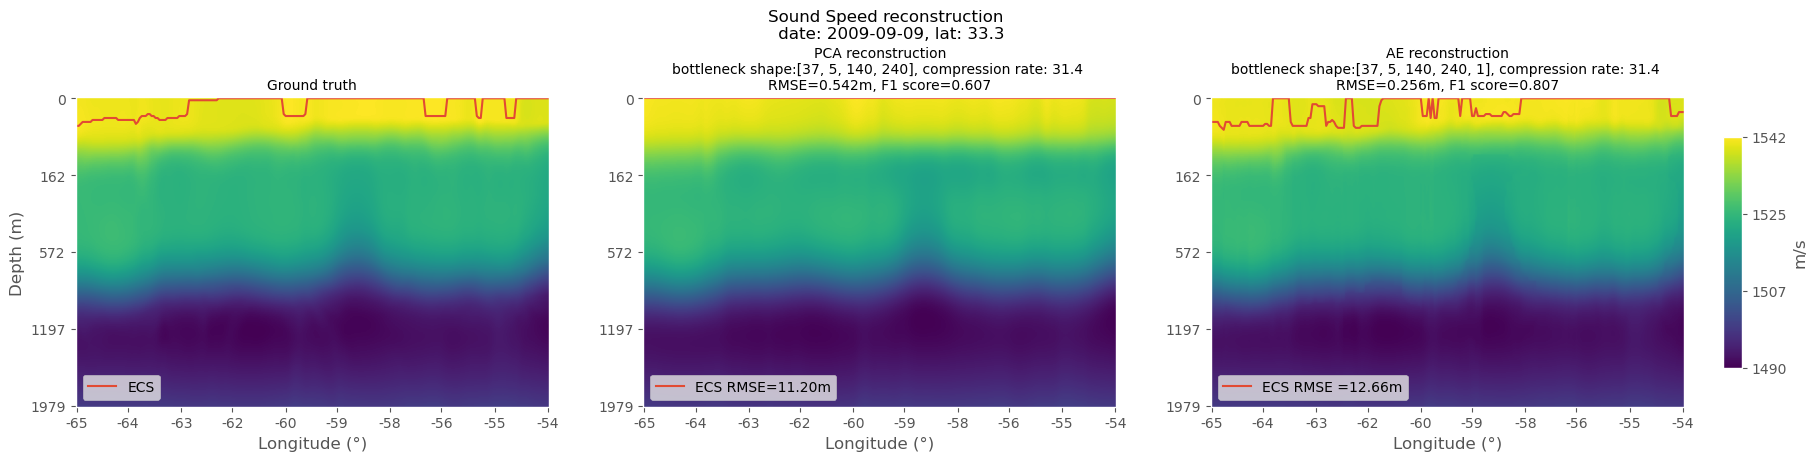

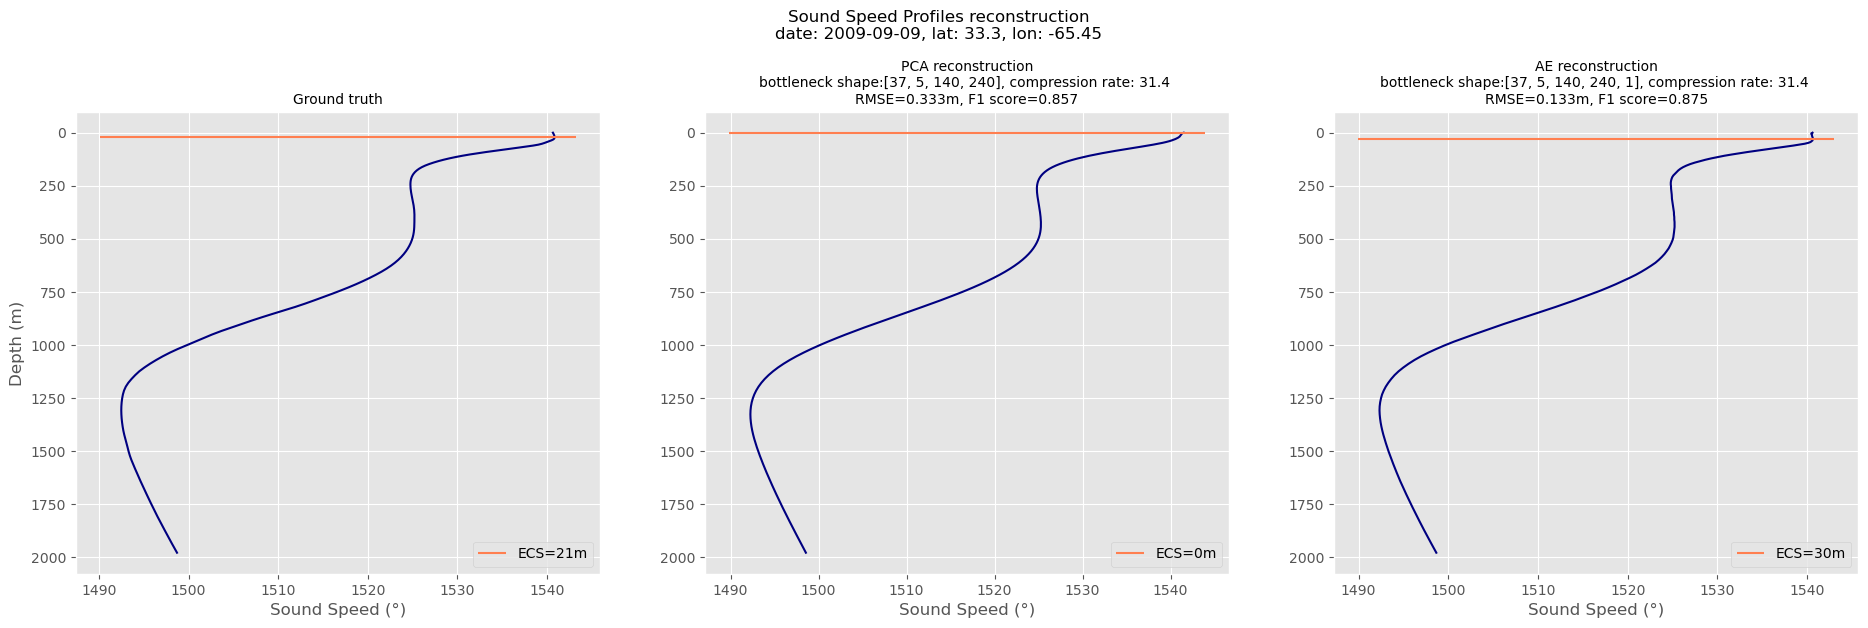

100%|██████████| 1/1 [00:15<00:00, 15.55s/it]


Model: 5_channels_80_epochs 



  0%|          | 0/1 [00:00<?, ?it/s]

outputs/visualisation/plot_3D/5_channels_80_epochs/upsample_mode_trilinear/linear_layer_False/cr_100000/1_conv_per_layer/padding_cubic/interp_size_5/final_upsample_upsample/act_fn_LeakyRelu/use_final_act_fn_True/lr_0.001/normalization_mean_std_along_depth/manage_nan_supress_with_max_depth/n_profiles_None/2025-02-24_23-46/checkpoints/val_loss=0.01-epoch=73.ckpt


/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
/tmp/ipykernel_2732567/2878606.py:31: RuntimeWarning: invalid value encountered in divide
  recall_score = np.where(recall_den == 0, 0, num_true_positives / recall_den)
/tmp/ipykernel_2732567/2878606.py:35: RuntimeWarning: invalid value encountered in divide
  f1_score = np.where(sum_scores == 0, 0, 2 * (precision_score * recall_score) / sum_scores)


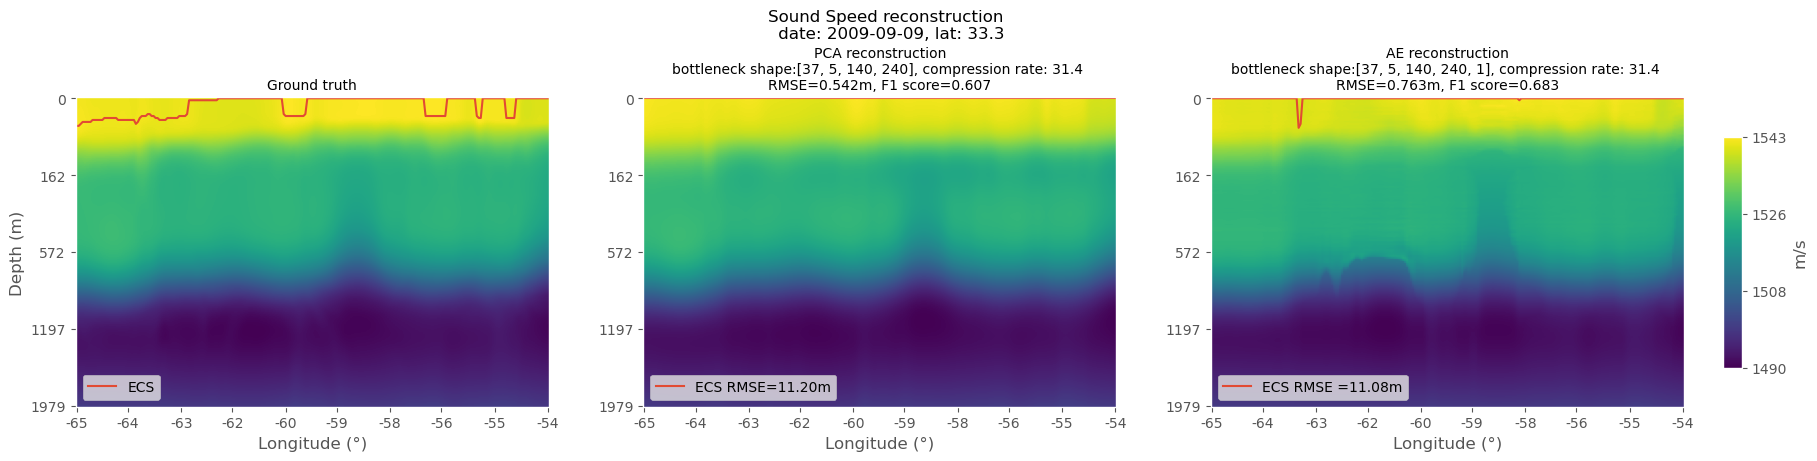

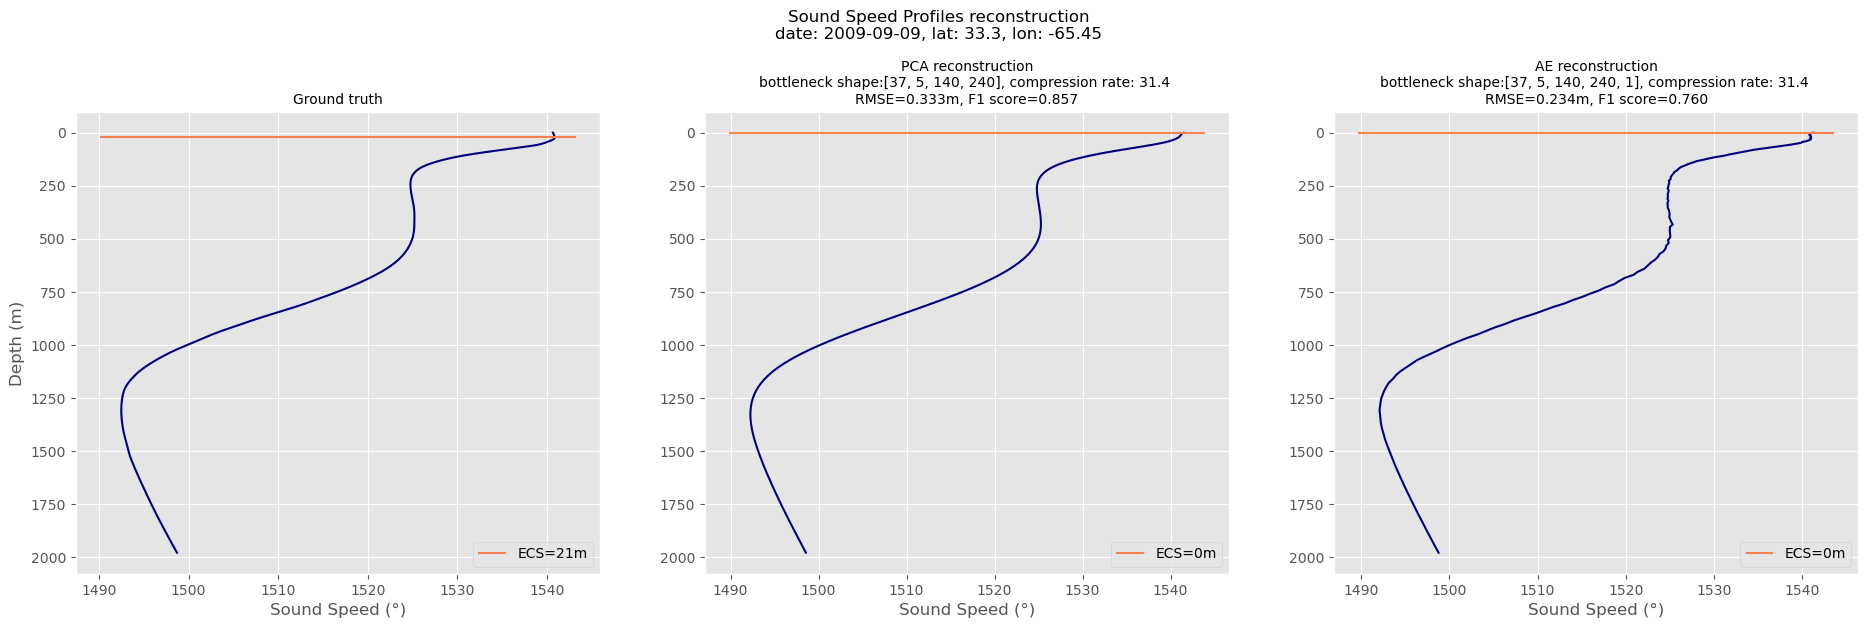

100%|██████████| 1/1 [00:13<00:00, 13.07s/it]


Model: 5_channels_400_epochs_grad_1 



  0%|          | 0/1 [00:00<?, ?it/s]/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


outputs/visualisation/plot_3D/5_channels_400_epochs_grad_1/checkpoints/val_loss=0.10-epoch=394.ckpt


/tmp/ipykernel_2732567/2878606.py:31: RuntimeWarning: invalid value encountered in divide
  recall_score = np.where(recall_den == 0, 0, num_true_positives / recall_den)
/tmp/ipykernel_2732567/2878606.py:35: RuntimeWarning: invalid value encountered in divide
  f1_score = np.where(sum_scores == 0, 0, 2 * (precision_score * recall_score) / sum_scores)


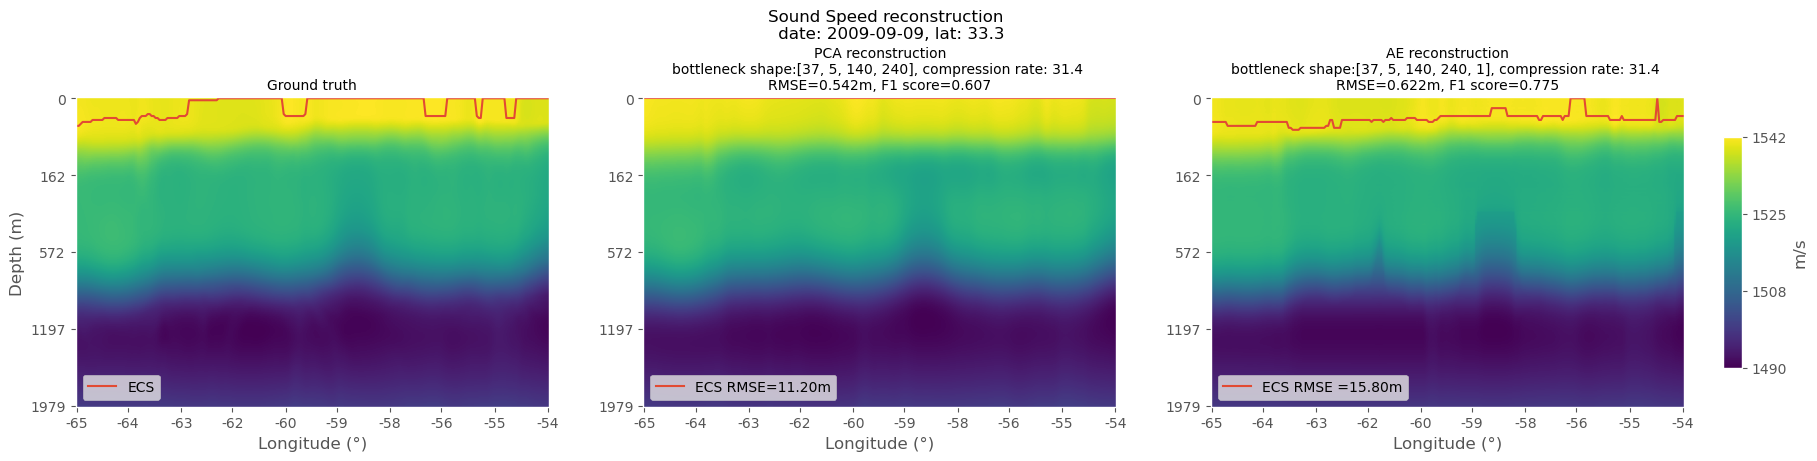

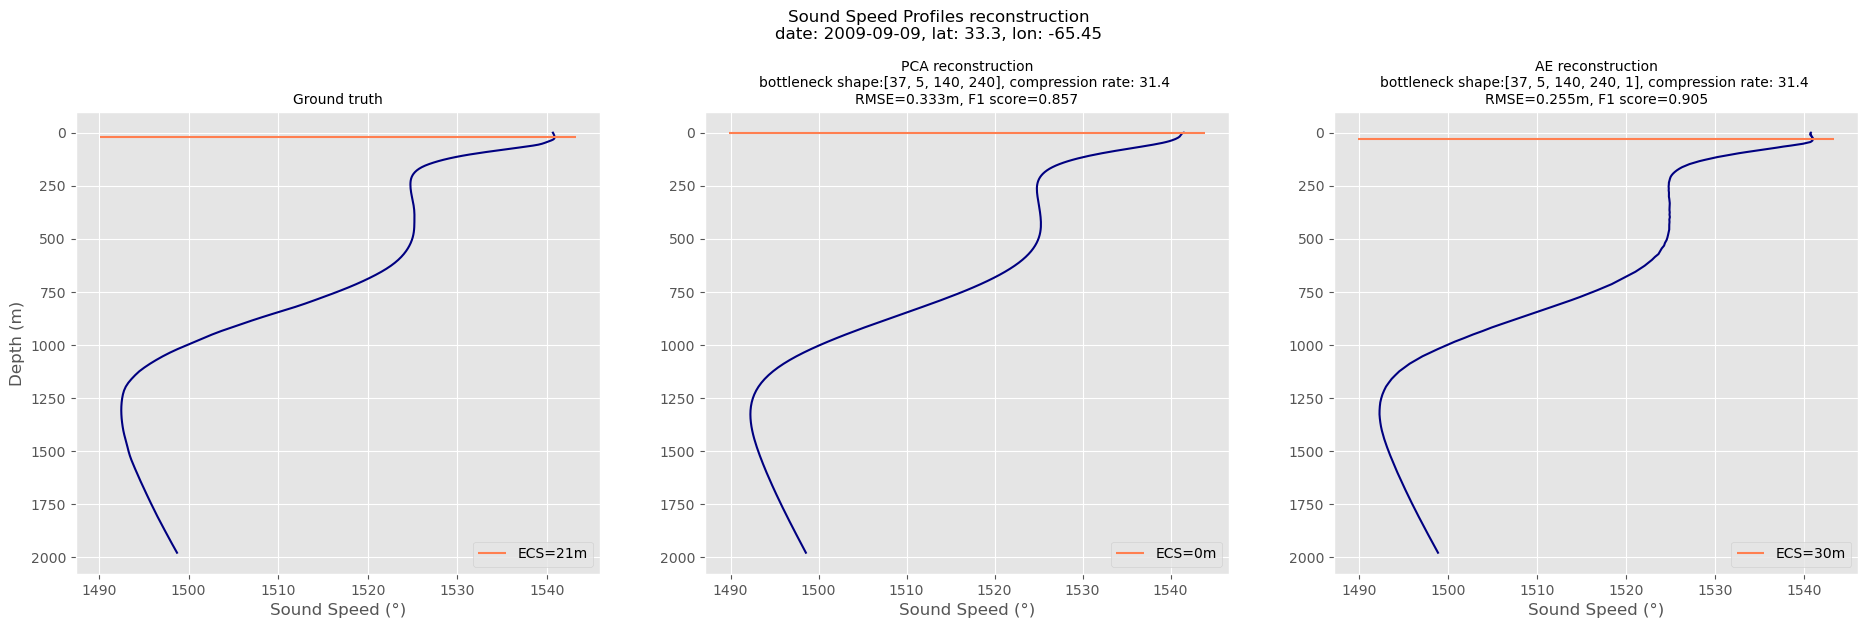

100%|██████████| 1/1 [00:12<00:00, 12.70s/it]


Model: 5_channels_400_epochs 



  0%|          | 0/1 [00:00<?, ?it/s]/Odyssey/private/o23gauvr/miniforge3/envs/fsc_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


outputs/visualisation/plot_3D/5_channels_400_epochs/checkpoints/val_loss=0.00-epoch=360.ckpt


/tmp/ipykernel_2732567/2878606.py:31: RuntimeWarning: invalid value encountered in divide
  recall_score = np.where(recall_den == 0, 0, num_true_positives / recall_den)
/tmp/ipykernel_2732567/2878606.py:35: RuntimeWarning: invalid value encountered in divide
  f1_score = np.where(sum_scores == 0, 0, 2 * (precision_score * recall_score) / sum_scores)


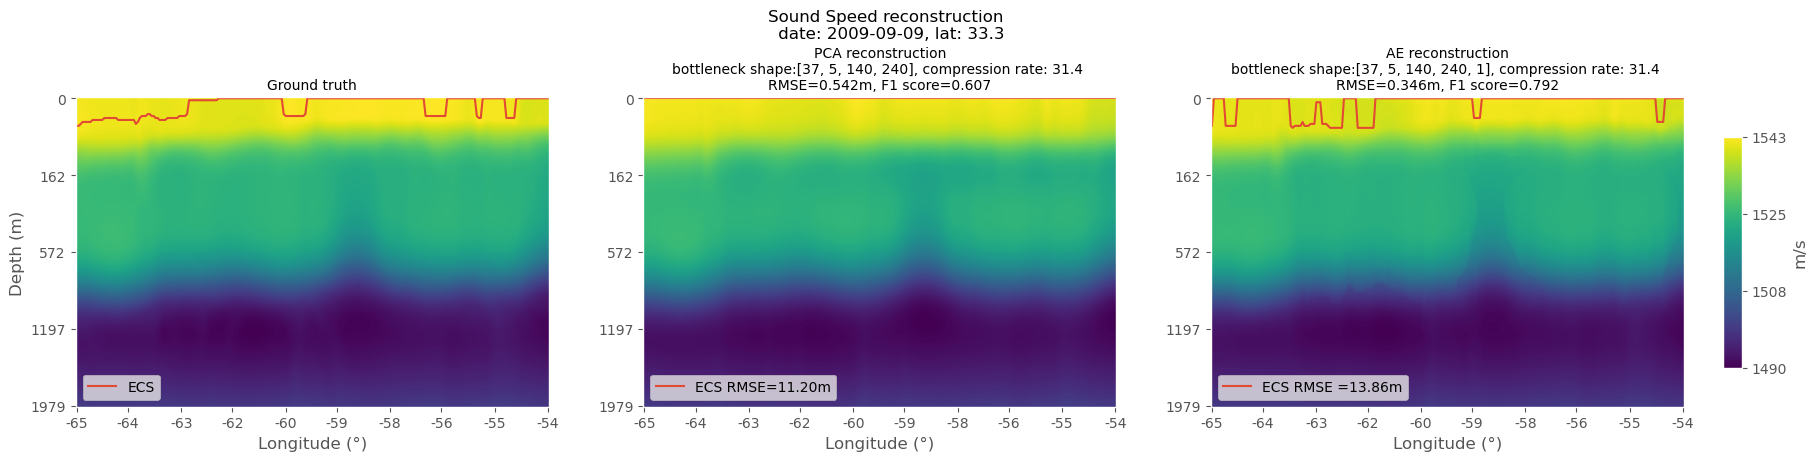

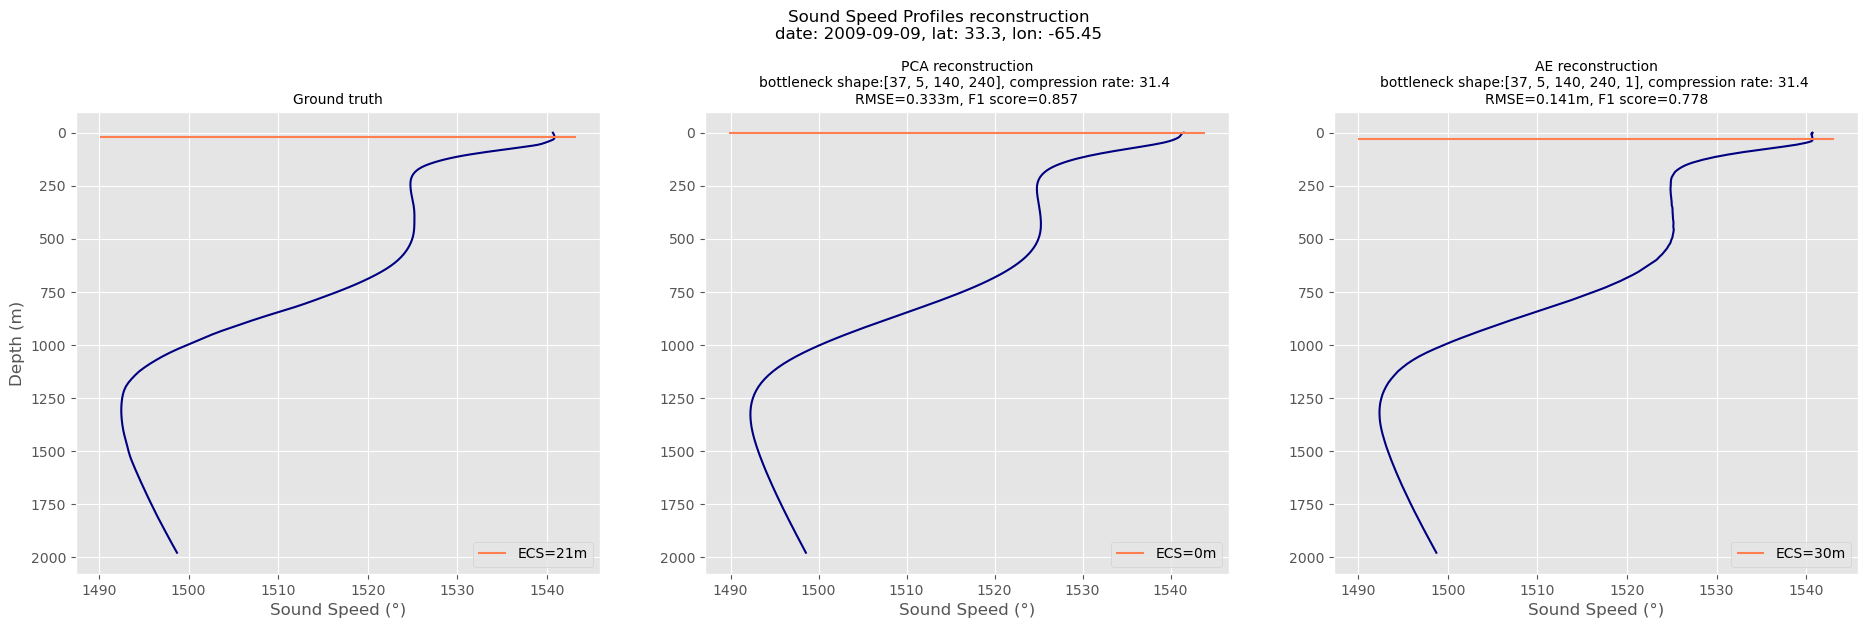

100%|██████████| 1/1 [00:12<00:00, 12.17s/it]


In [16]:

from IPython.display import display, HTML

# t,lat = 9,104
# lon = 90
t,lat,lon = 10,10,10

for model_name in ckpt_dict.keys():

    print(f"Model: {model_name} \n")

    ckpt_list = list(Path(ckpt_dict[model_name]).rglob('*.ckpt'))

    for ckpt_path in tqdm(ckpt_list):
        
        ckpt_path = str(ckpt_path)

        print(ckpt_path)

        try:
            cfg = get_cfg_from_ckpt_path(ckpt_path, pprint = False)        

        except:
            print(f"Can't load config")
            continue
        
        
    
        
        if cfg.datamodule in list(dm_dict.keys()):
            dm = dm_dict[cfg.datamodule]
            test_truth_ssp_arr, dm = loading_datamodule_phase(dm,phase="test")
            test_ssp_truth_tens = torch.tensor(test_truth_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)



        
        else:

            print("Inititing datamodule; Generating train and test datasets")
            
            dm = hydra.utils.call(cfg.datamodule)  
            test_truth_ssp_arr, dm = loading_datamodule_phase(dm,phase="test")
            test_ssp_truth_tens = torch.tensor(test_truth_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)
            dm_dict[cfg.datamodule] = dm

            

        
        try:
            lit_model = load_model(ckpt_path, dm, test_ssp_truth_tens, verbose = True)    

            # with torch.no_grad():
            #     # Initialize encoder weights and bias for identity function
            #     conv_weights = lit_model.encoder.net[0].weight
            #     conv_weights.fill_(0)
            #     conv_weights[:, :, 3, 3, 3] = 1  # Assuming kernel size is 7x7x7

            #     lit_model.encoder.net[0].bias.fill_(0)

            #     # Initialize decoder weights and bias for identity function
            #     conv_weights = lit_model.decoder.net[0].weight
            #     conv_weights.fill_(0)
            #     conv_weights[:, :, 3, 3, 3] = 1  # Assuming kernel size is 7x7x7

            #     lit_model.decoder.net[0].bias.fill_(0)

        except:
            print("Can't load model ")
            continue

        test_ae_ssp_arr = lit_model(test_ssp_truth_tens).detach().cpu().numpy()
        ae_bottleneck_shape = lit_model.model_AE.bottleneck_shape
        
        test_ssp_truth_arr = test_ssp_truth_tens.detach().cpu().numpy()

        if dm.norm_stats["norm_location"] == "datamodule":
            test_truth_ssp_arr = unorm_ssp_arr_3D(test_ssp_truth_arr, dm)
            test_ae_ssp_arr = unorm_ssp_arr_3D(test_ae_ssp_arr, dm)
        

        ssp_shape = test_truth_ssp_arr.shape
        
        cr = lit_model.model_AE.cr
        ae_bottleneck_shape = lit_model.model_AE.bottleneck_shape
        n_components = min(ae_bottleneck_shape[1],ssp_shape[1])
        n_layer = (ssp_shape[-1]//ae_bottleneck_shape[-2])-1

        # n_layer = math.floor(math.log(cr,4)) - 1
        # spatail_cr = ssp_shape[2]/math.ceil(ssp_shape[2]/2**n_layer) * ssp_shape[3]/math.ceil(ssp_shape[3]/2**n_layer)
        # n_components = int((ssp_shape[1]*spatail_cr)//cr)
        # #n_components = int((ssp_shape[1]*4**n_layer)//cr)

        # if n_components <= 2:
        #     n_layer = n_layer + 1
        #     spatail_cr = ssp_shape[2]/math.ceil(ssp_shape[2]/2**n_layer) * ssp_shape[3]/math.ceil(ssp_shape[3]/2**n_layer)
        #     n_components = int((ssp_shape[1]*spatail_cr)//cr)
        

        

        #pca = pca_dict[n_components]

        if n_components in list(pca_dict.keys()):
            pca = pca_dict[n_components]
        else:
            print("Fitting PCA")
            train_truth_ssp_arr, dm = loading_datamodule_phase(dm,phase="fit")
            train_truth_ssp_arr = unorm_ssp_arr_3D(train_truth_ssp_arr,dm)

            pca = PCA(n_components = n_components)
            pca.fit(train_truth_ssp_arr.transpose(0,2,3,1).reshape(-1,train_truth_ssp_arr.shape[1]))
            pca_dict[n_components] = pca


        #test_pca_ssp_arr = pca.inverse_transform(pca.transform(test_truth_ssp_arr.transpose(0,2,3,1).reshape(-1,ssp_shape[1]))).reshape(ssp_shape[0],ssp_shape[2],ssp_shape[3],ssp_shape[1]).transpose(0,3,1,2)
        
        pca_reduced_test_ssp_tens = torch.tensor(pca.transform(test_truth_ssp_arr.transpose(0,2,3,1).reshape(-1,ssp_shape[1])).reshape(ssp_shape[0],ssp_shape[2],ssp_shape[3],n_components).transpose(0,3,1,2), dtype=getattr(torch,cfg.dtype), device=device)

        
        model_pool_pca = NoConvAE(n_layer, pooling_dim="spatial", pooling_mode="Avg")
        pooled_upsampled_pca_test_ssp_tens = model_pool_pca(pca_reduced_test_ssp_tens)

        pca_bottleneck_shape = model_pool_pca.bottleneck_shape

        test_pca_ssp_arr = pca.inverse_transform(pooled_upsampled_pca_test_ssp_tens.detach().cpu().numpy().transpose(0,2,3,1).reshape(-1,n_components)).reshape(ssp_shape[0],ssp_shape[2],ssp_shape[3],ssp_shape[1]).transpose(0,3,1,2)


        bottleneck_shape_tuple = (ae_bottleneck_shape, pca_bottleneck_shape)


        b, a = butter(N=2, Wn=0.15, btype='low', analog=False)
        filtered_ae_test_arr = filtfilt(b, a, test_ae_ssp_arr, axis=1)
        
        ##worst ssp
        ssp_mse = np.mean((test_truth_ssp_arr-test_ae_ssp_arr)**2,axis=(1,3))
        rmse_ssp_lat_lon = np.sqrt(np.mean((test_truth_ssp_arr-test_ae_ssp_arr)**2,axis=(0,1)))

        t_max_ssp, lat_max_ssp = np.unravel_index(np.argmax(ssp_mse), ssp_mse.shape)
        lon_max_ssp = np.argmax(np.mean((test_truth_ssp_arr[t_max_ssp,:,lat_max_ssp,:]-test_ae_ssp_arr[t_max_ssp,:,lat_max_ssp,:])**2,axis = 0))

        t_min_ssp, lat_min_ssp = np.unravel_index(np.argmin(ssp_mse), ssp_mse.shape)
        lon_min_ssp = np.argmin(np.mean((test_truth_ssp_arr[t_min_ssp,:,lat_min_ssp,:]-test_ae_ssp_arr[t_min_ssp,:,lat_min_ssp,:])**2,axis = 0))

        min_max_idx_truth = get_min_max_idx(test_truth_ssp_arr, pad=False)
        min_max_idx_ae = get_min_max_idx(test_ae_ssp_arr, pad=False)

        f1_score = get_f1_score(min_max_idx_truth, min_max_idx_ae)

        t_max_f1, lat_max_f1, lon_max_f1 = np.unravel_index(np.argmax(f1_score), f1_score.shape)
        #lon_max_f1 = np.argmax(np.mean((f1_score[t_max_f1,lat_max_f1,:]-f1_score[t_max_f1,lat_max_f1,:])**2,axis = 0))

        t_min_f1, lat_min_f1, lon_min_f1 = np.unravel_index(np.argmin(f1_score), f1_score.shape)
        #lon_min_f1 = np.argmin(np.mean((f1_score[t_min_f1,lat_min_f1,:]-f1_score[t_min_f1,lat_min_f1,:])**2,axis = 0))

        ecs_truth = dm.depth_array[np.argmax(test_truth_ssp_arr,axis=1)]
        ecs_pred = dm.depth_array[np.argmax(test_ae_ssp_arr,axis=1)]
        rmse_lat_lon = np.sqrt(np.mean((test_truth_ssp_arr-test_ae_ssp_arr)**2,axis=(0,1)))


        ecs_mse = np.mean((ecs_truth-ecs_pred)**2,axis=(2))
        rmse_ecs_lat_lon = np.sqrt(np.mean((ecs_truth-ecs_pred)**2,axis=(0)))


        t_max_ecs, lat_max_ecs = np.unravel_index(np.argmax(ecs_mse), ecs_mse.shape)
        lon_max_ecs = np.argmax((ecs_truth[t_max_ecs, lat_max_ecs,:]-ecs_pred[t_max_ecs, lat_max_ecs,:])**2)





        plot_ssp_2D(test_truth_ssp_arr,
                        test_pca_ssp_arr,
                        test_ae_ssp_arr, 
                        dm,
                        bottleneck_shape_tuple,
                        t,
                        lat)


        plot_ssp_profiles(test_truth_ssp_arr,
                                test_pca_ssp_arr,
                                test_ae_ssp_arr, 
                                dm,
                                bottleneck_shape_tuple,
                                t,
                                lat,
                                lon)
        
        plt.show()
        

        
        # display(HTML(f"<span style='font-size:20px;'>Worst SSP reconstruction: t_max_ssp: {t_max_ssp}, lat_max_ssp: {lat_max_ssp}, lon_max_ssp: {lon_max_ssp}</span>"))

        # plot_ssp_2D(test_truth_ssp_arr,
        #                 test_pca_ssp_arr,
        #                 test_ae_ssp_arr, 
        #                 dm,
        #                 bottleneck_shape_tuple,
        #                 t_max_ssp,
        #                 lat_max_ssp)


        # plot_ssp_profiles(test_truth_ssp_arr,
        #                         test_pca_ssp_arr,
        #                         test_ae_ssp_arr, 
        #                         dm,
        #                         bottleneck_shape_tuple,
        #                         t_max_ssp,
        #                         lat_max_ssp,
        #                         lon_max_ssp)
        
        # display(HTML(f"<span style='font-size:20px;'>Best SSP reconstruction: t_min_ssp: {t_min_ssp}, lat_min_ssp: {lat_min_ssp}, lon_min_ssp: {lon_min_ssp}</span>"))

        # plot_ssp_2D(test_truth_ssp_arr,
        #                 test_pca_ssp_arr,
        #                 test_ae_ssp_arr, 
        #                 dm,
        #                 bottleneck_shape_tuple,
        #                 t_min_ssp,
        #                 lat_min_ssp)


        # plot_ssp_profiles(test_truth_ssp_arr,
        #                         test_pca_ssp_arr,
        #                         test_ae_ssp_arr, 
        #                         dm,
        #                         bottleneck_shape_tuple,
        #                         t_min_ssp,
        #                         lat_min_ssp,
        #                         lon_min_ssp)

        # display(HTML(f"<span style='font-size:20px;'>Worst F1 reconstruction: t_max_f1: {t_max_f1}, lat_max_f1: {lat_max_f1}, lon_max_f1: {lon_max_f1}</span>"))

        # plot_ssp_2D(test_truth_ssp_arr,
        #                   test_pca_ssp_arr,
        #                   test_ae_ssp_arr, 
        #                   dm,
        #                   bottleneck_shape_tuple,
        #                   t_min_f1,
        #                   lat_min_f1)

        # plot_ssp_profiles(test_truth_ssp_arr,
        #                         test_pca_ssp_arr,
        #                         test_ae_ssp_arr, 
        #                         dm,
        #                         bottleneck_shape_tuple,
        #                         t_min_f1,
        #                         lat_min_f1,
        #                         lon_min_f1)

        # display(HTML(f"<span style='font-size:20px;'>Best F1 reconstruction: t_min_f1: {t_min_f1}, lat_min_f1: {lat_min_f1}, lon_min_f1: {lon_min_f1}</span>"))

        # plot_ssp_2D(test_truth_ssp_arr,
        #                   test_pca_ssp_arr,
        #                   test_ae_ssp_arr, 
        #                   dm,
        #                   bottleneck_shape_tuple,
        #                   t_max_f1,
        #                   lat_max_f1)

        # plot_ssp_profiles(test_truth_ssp_arr,
        #                         test_pca_ssp_arr,
        #                         test_ae_ssp_arr, 
        #                         dm,
        #                         bottleneck_shape_tuple,
        #                         t_max_f1,
        #                         lat_max_f1,
        #                         lon_max_f1)

        # display(HTML(f"<span style='font-size:20px;'>Worst F1 reconstruction (Filtered): t_max_f1: {t_max_f1}, lat_max_f1: {lat_max_f1}, lon_max_f1: {lon_max_f1}</span>"))

        # plot_ssp_2D(test_truth_ssp_arr,
        #                   test_pca_ssp_arr,
        #                   filtered_ae_test_arr, 
        #                   dm,
        #                   bottleneck_shape_tuple,
        #                   t_min_f1,
        #                   lat_min_f1)

        # plot_ssp_profiles(test_truth_ssp_arr,
        #                         test_pca_ssp_arr,
        #                         filtered_ae_test_arr, 
        #                         dm,
        #                         bottleneck_shape_tuple,
        #                         t_min_f1,
        #                         lat_min_f1,
        #                         lon_min_f1)

        

        # display(HTML(f"<span style='font-size:20px;'>Best F1 reconstruction (Filtered): t_min_f1: {t_min_f1}, lat_min_f1: {lat_min_f1}, lon_min_f1: {lon_min_f1}</span>"))

        # plot_ssp_2D(test_truth_ssp_arr,
        #                   test_pca_ssp_arr,
        #                   filtered_ae_test_arr, 
        #                   dm,
        #                   bottleneck_shape_tuple,
        #                   t_max_f1,
        #                   lat_max_f1)

        # plot_ssp_profiles(test_truth_ssp_arr,
        #                         test_pca_ssp_arr,
        #                         filtered_ae_test_arr, 
        #                         dm,
        #                         bottleneck_shape_tuple,
        #                         t_max_f1,
        #                         lat_max_f1,
        #                         lon_max_f1)



        # #Plot RMSE with a red and white colormap
        # plt.figure(figsize=(10, 5))
        # plt.imshow(rmse_ssp_lat_lon, origin='lower', aspect='auto', extent=[dm.test_ds.input.coords["lon"].values.min(), dm.test_ds.input.coords["lon"].values.max(), dm.test_ds.input.coords["lat"].values.min(), dm.test_ds.input.coords["lat"].values.max()], cmap='Reds')
        # plt.colorbar(label='RMSE (m/s)')
        # plt.clim(0, 20)
        # plt.xticks(ticks=np.arange(np.ceil(min(dm.test_ds.input.coords["lon"].values)), np.ceil(max(dm.test_ds.input.coords["lon"].values)), 1))
        # plt.yticks(ticks=np.arange(np.ceil(min(dm.test_ds.input.coords["lat"].values)), np.ceil(max(dm.test_ds.input.coords["lat"].values)), 1))
        # plt.xlabel('Longitude')
        # plt.ylabel('Latitude')
        # plt.title('RMSE over SSP across Latitude and Longitude')
        # plt.grid(False)
        # plt.show()
        
        # display(HTML(f"<span style='font-size:20px;'>Worst ECS reconstruction: t_max_ssp: {t_max_ecs}, lat_max_ssp: {lat_max_ecs}, lon_max_ssp: {lon_max_ecs}</span>"))

        # plot_ssp_2D(test_truth_ssp_arr,
        #         test_pca_ssp_arr,
        #         test_ae_ssp_arr, 
        #         dm,
        #         bottleneck_shape_tuple,
        #         t_max_ecs,
        #         lat_max_ecs)


        # plot_ssp_profiles(test_truth_ssp_arr,
        #                         test_pca_ssp_arr,
        #                         test_ae_ssp_arr, 
        #                         dm,
        #                         bottleneck_shape_tuple,
        #                         t_max_ecs,
        #                         lat_max_ecs,
        #                         lon_max_ecs)
        

        # plt.figure(figsize=(10, 5))
        # plt.imshow(rmse_ecs_lat_lon, origin='lower', aspect='auto', extent=[dm.test_ds.input.coords["lon"].values.min(), dm.test_ds.input.coords["lon"].values.max(), dm.test_ds.input.coords["lat"].values.min(), dm.test_ds.input.coords["lat"].values.max()], cmap='Reds')
        # plt.colorbar(label='RMSE (m)')
        # plt.clim(0, 250)
        # plt.xticks(ticks=np.arange(np.ceil(min(dm.test_ds.input.coords["lon"].values)), np.ceil(max(dm.test_ds.input.coords["lon"].values)), 1))
        # plt.yticks(ticks=np.arange(np.ceil(min(dm.test_ds.input.coords["lat"].values)), np.ceil(max(dm.test_ds.input.coords["lat"].values)), 1))
        # plt.xlabel('Longitude')
        # plt.ylabel('Latitude')
        # plt.title('RMSE over ECS across Latitude and Longitude')
        # plt.grid(False)


        
        # plt.show()


# Filter profiles